# Применение простейших моделей

Загружаем файлы и необходимые библиотеки

In [ ]:
PATH="/content/drive/My Drive/" # Путь до файлов

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # Получаем доступ к гугл диску, чтобы взять оттуда данные

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Импортируем библиотеки
!pip install optuna
!pip install catboost
!pip install category_encoders
!pip install pickle

import pickle
import optuna
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

import torch
from torch import nn, optim
from torch.functional import F

import math

import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders.leave_one_out import LeaveOneOutEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,precision_score, recall_score, roc_auc_score

#from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score


from catboost import CatBoostClassifier
import catboost as cb


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [ ]:
path_merged_=PATH+"merge_filled_without drop.parquet" # объединенные transaction и identity

merged = pd.read_parquet(path_merged_)

In [ ]:
merged.memory_usage().sum() / 1024**2

1955.3709106445312

In [ ]:
# Заметим, что все числовые столбцы имели тип int64 или float64.
# В результате объединенный датасет занимает почти 2 GB памяти.
# При обучении моделей google colab периодически падал по памяти, 
# поэтому было решено поработать дополнительно с типами столбцов.


for col in merged.columns:
  col_type = merged[col].dtype

  if col_type != object:
      min_ = merged[col].min()
      max_ = merged[col].max()
      if str(col_type)[:3] == 'int':
          if min_ > np.iinfo(np.int8).min and max_ < np.iinfo(np.int8).max:
              merged[col] = merged[col].astype(np.int8)
          elif min_ > np.iinfo(np.int16).min and max_ < np.iinfo(np.int16).max:
              merged[col] = merged[col].astype(np.int16)
          elif min_ > np.iinfo(np.int32).min and max_ < np.iinfo(np.int32).max:
              merged[col] = merged[col].astype(np.int32)
          elif min_ > np.iinfo(np.int64).min and max_ < np.iinfo(np.int64).max:
              merged[col] = merged[col].astype(np.int64)  
      else:
          if min_ > np.finfo(np.float16).min and max_ < np.finfo(np.float16).max:
              merged[col] = merged[col].astype(np.float16)
          elif min_ > np.finfo(np.float32).min and max_ < np.finfo(np.float32).max:
              merged[col] = merged[col].astype(np.float32)
          else:
              merged[col] = merged[col].astype(np.float64)
  else:
      merged[col] = merged[col].astype('category')


In [ ]:
merged.memory_usage().sum() / 1024**2 #Так намного лучше :)

525.5524215698242

In [ ]:
merged

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.500000,W,13926,362.5,150.0,discover,142.0,...,n/d,26.515625,n/d,n/d,n/d,n/d,n/d,n/d,n/d,n/d
1,2987001,0,86401,29.000000,W,2755,404.0,150.0,mastercard,102.0,...,n/d,26.515625,n/d,n/d,n/d,n/d,n/d,n/d,n/d,n/d
2,2987002,0,86469,59.000000,W,4663,490.0,150.0,visa,166.0,...,n/d,26.515625,n/d,n/d,n/d,n/d,n/d,n/d,n/d,n/d
3,2987003,0,86499,50.000000,W,18132,567.0,150.0,mastercard,117.0,...,n/d,26.515625,n/d,n/d,n/d,n/d,n/d,n/d,n/d,n/d
4,2987004,0,86506,50.000000,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.000000,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.000000,W,6550,362.5,150.0,visa,226.0,...,n/d,26.515625,n/d,n/d,n/d,n/d,n/d,n/d,n/d,n/d
590536,3577536,0,15811049,39.500000,W,10444,225.0,150.0,mastercard,224.0,...,n/d,26.515625,n/d,n/d,n/d,n/d,n/d,n/d,n/d,n/d
590537,3577537,0,15811079,30.953125,W,12037,595.0,150.0,mastercard,224.0,...,n/d,26.515625,n/d,n/d,n/d,n/d,n/d,n/d,n/d,n/d
590538,3577538,0,15811088,117.000000,W,7826,481.0,150.0,mastercard,224.0,...,n/d,26.515625,n/d,n/d,n/d,n/d,n/d,n/d,n/d,n/d


Выделим отдельно списки числовых столбцов и категориальных

In [ ]:
numeric_col_id=np.where(merged.dtypes != 'category')[0]
numeric_col = merged.columns[numeric_col_id].drop("isFraud")

In [ ]:
categorical_col_id=np.where(merged.dtypes == 'category')[0]
categorical_col=merged.columns[categorical_col_id]

Разделим на тестовую и обучающую выборки

In [ ]:
X= merged.drop('isFraud', axis=1)
y= merged['isFraud']
   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

##Undersampling

In [ ]:
und=RandomUnderSampler(random_state=42)

X_und, y_und = und.fit_resample(X_train, y_train)

print(f'Разбиение на классы до undersampling: {Counter(y_train)}')
print(f'Разбиение на классы после: {Counter(y_und)}')

Разбиение на классы до undersampling: Counter({0: 399056, 1: 14322})
Разбиение на классы после: Counter({0: 14322, 1: 14322})


##LogisticRegression

In [ ]:
pipe_lr_rs = Pipeline([
    ('encoder', LeaveOneOutEncoder(cols=categorical_col)),
    ('scaler', StandardScaler()),
    ('selector', SelectFromModel(LogisticRegression(penalty='l1', max_iter=5000, class_weight='balanced',  solver='liblinear'), threshold=0.1)), 
    ('model', LogisticRegression(max_iter=6000, class_weight='balanced'))])

In [ ]:
def objective(trial):

    classifier_name = trial.suggest_categorical("classifier", ["LogReg"])
    
    # Step 2. Setup values for the hyperparameters:
    if classifier_name == 'LogReg':
        logreg_c = trial.suggest_float("logreg_c", 1e-10, 100, log=True)
        logreg_sigma = trial.suggest_float("logreg_sigma", 40, 70, log=True)
        classifier_obj = pipe_lr_rs.set_params(model__C=logreg_c, encoder__sigma=logreg_sigma)
    
        
    # Step 3: Scoring method:
    score = cross_val_score(classifier_obj, X_und, y_und, n_jobs=-1, cv=3, scoring='roc_auc')
    accuracy = score.mean()
    return accuracy
  
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2022-12-23 09:04:30,614] A new study created in memory with name: no-name-ad770f77-3761-46e4-8c6e-f21687806bd7
[I 2022-12-23 09:07:22,604] Trial 0 finished with value: 0.7871994722846786 and parameters: {'classifier': 'LogReg', 'logreg_c': 2.445151333099112e-07, 'logreg_sigma': 54.524213274784856}. Best is trial 0 with value: 0.7871994722846786.
[I 2022-12-23 09:10:15,181] Trial 1 finished with value: 0.8377024995806838 and parameters: {'classifier': 'LogReg', 'logreg_c': 0.0033218634003296206, 'logreg_sigma': 61.07223982410067}. Best is trial 1 with value: 0.8377024995806838.
[I 2022-12-23 09:13:26,194] Trial 2 finished with value: 0.7878242928650377 and parameters: {'classifier': 'LogReg', 'logreg_c': 2.255027701617845e-10, 'logreg_sigma': 57.69540313416346}. Best is trial 1 with value: 0.8377024995806838.
[I 2022-12-23 09:15:54,589] Trial 3 finished with value: 0.8331164209476843 and parameters: {'classifier': 'LogReg', 'logreg_c': 0.0012715186407280294, 'logreg_sigma': 56.537140

In [ ]:
pipe_lr_rs.set_params(model__C=47.302996633472, encoder__sigma=68.3562567234045).fit(X_und, y_und)

Pipeline(steps=[('encoder',
                 LeaveOneOutEncoder(cols=Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
       'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15',
       'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33',
       'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType',
       'DeviceInfo'],
      dtype='object'),
                                    sigma=68.3562567234045)),
                ('scaler', StandardScaler()),
                ('selector',
                 SelectFromModel(estimator=LogisticRegression(class_weight='balanced',
                                                              max_iter=5000,
                                                              penalty='l1',
                                                              solver='liblinear'),
                                 threshold=0.1)),
                ('model',
                 LogisticRegression(C=47.302996633472,

In [ ]:
pickle.dump(pipe_lr_rs, open(PATH+'pipe_lr_rs.pkl', 'wb'))

In [ ]:
pred = pipe_lr_rs.predict(X_test)

# Оценим качество
ras = roc_auc_score(y_test, pred)
f = f1_score(y_test, pred, average='micro')
pr = precision_score(y_test, pred)
rc = recall_score(y_test, pred)


print(f'ROC_AUC: {ras}')
print(f'f1: {f}')
print(f'precision_score: {pr}')
print(f'recall_score: {rc}')

ROC_AUC: 0.7754437549782367
f1: 0.8343154852620766
precision_score: 0.1409088071905624
recall_score: 0.7120328023970982


##OneHotEncoding

In [ ]:
scaler = StandardScaler()

# Категориальный фичи будем кадировать OHE
ohe = OneHotEncoder(handle_unknown='ignore')


column_trans = ColumnTransformer(
    [ ('scaler',scaler, numeric_col),
    ('ohe', ohe, categorical_col)], remainder='passthrough', n_jobs=-1)

train_X_transformed = column_trans.fit_transform(X_und, y_und)
test_X_transformed = column_trans.transform(X_test)

print(train_X_transformed.shape)

(28644, 1400)


##LogisticRegression v2

Попробуем обучить однослойную сеть с сигмоидой - по сути это будет логистическая регрессия, но можно обучить на GPU

In [ ]:
y_tensor = torch.from_numpy(y_und.values.reshape(-1, 1)).float()
X_tensor = torch.from_numpy(pd.DataFrame(train_X_transformed).values).float()
test_X_tensor = torch.from_numpy(pd.DataFrame(test_X_transformed).values).float()
y_tensor_test= torch.from_numpy(y_test.values.reshape(-1, 1)).float()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
X_tensor=X_tensor.to(device)
y_tensor=y_tensor.to(device)

In [ ]:
epochs = 60000
learning_rate = 0.00001

class LogisticRegressionTorch(nn.Module):
    def __init__(self, input_size, output_size):
        super(LogisticRegressionTorch, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, X):
        predictions = self.linear(X)
        return torch.sigmoid(predictions)

model = LogisticRegressionTorch(X_tensor.shape[1], y_tensor.shape[1])
model=model.cuda()

# определяем функцию потерь — бинарную кросс-энтропию
criterion = nn.BCELoss()
# в качестве алгоритма оптимизации выберем Adam
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = model(X_tensor)
    loss = criterion(predictions, y_tensor)
    # вычисляем градиенты
    loss.backward()
    # обновляем параметры
    optimizer.step()

predictions = model(X_tensor)

print(roc_auc_score(y_tensor.cpu(), predictions.cpu().detach().numpy()))

0.8086589169082378


In [ ]:
predictions_test = model(test_X_tensor.to(device))
print(roc_auc_score(y_tensor_test, predictions_test.cpu().detach().numpy()))

0.8098003787770545


Результаты получили схожие, но быстрее

## CatBoost

In [ ]:
def objective(trial, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    X= merged.drop('isFraud', axis=1)
    y= merged['isFraud']
    categorical_features_indices = np.where(X.dtypes == 'category')[0]

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "task_type":"GPU",
        "eval_metric": "AUC",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cat_cls = CatBoostClassifier(**param)

    cat_cls.fit(X_train, y_train, eval_set=[(X_test, y_test)], cat_features=np.where(merged.dtypes == 'category')[0],verbose=0, early_stopping_rounds=100)

    preds = cat_cls.predict(X_test)
    pred_labels = np.rint(preds)
    roc_auc_ = roc_auc_score(y_test, pred_labels)
    return roc_auc_


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=50, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-12-20 20:41:15,459] A new study created in memory with name: no-name-203f29a8-0bb8-43da-b7db-c754f918d533
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2022-12-20 20:42:53,016] Trial 0 finished with value: 0.7302485620801181 and parameters: {'objective': 'Logloss', 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.076243181255637}. Best is trial 0 with value: 0.7302485620801181.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2022-12-20 20:44:13,582] Trial 1 finished with value: 0.7216652332076635 and parameters: {'objective': 'Logloss', 'depth': 2, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6048319631020951}. Best is trial 0 with value: 0.7302485620801181.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2022-12-20 20:44:33,541] Trial 2 finished with value: 0.5 and parameters: {'objective': 'CrossEntropy', 'depth': 1, 'boosting_t

Number of finished trials: 6
Best trial:
  Value: 0.8075325773408667
  Params: 
    objective: Logloss
    depth: 9
    boosting_type: Plain
    bootstrap_type: Bernoulli
    subsample: 0.5475743680450441


In [ ]:
accuracy =[]
model = CatBoostClassifier(verbose=True,random_state=42,
                          objective= 'Logloss',
    depth= 9,
    boosting_type= 'Plain',task_type="GPU",eval_metric="AUC",
    bootstrap_type= 'Bernoulli')

model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_test, y_test), plot=True)
y_pred = model.predict(X_test)
accuracy.append(round(roc_auc_score(y_test, y_pred),4))
print(classification_report(y_test, y_pred))

model_names = ['Catboost_tuned']
result_df6 = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
result_df6

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.042671


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7190179	best: 0.7190179 (0)	total: 280ms	remaining: 4m 40s
1:	total: 527ms	remaining: 4m 23s
2:	total: 720ms	remaining: 3m 59s
3:	total: 970ms	remaining: 4m 1s
4:	total: 1.22s	remaining: 4m 2s
5:	test: 0.8298542	best: 0.8298542 (5)	total: 1.46s	remaining: 4m 2s
6:	total: 1.68s	remaining: 3m 58s
7:	total: 1.93s	remaining: 3m 59s
8:	total: 2.17s	remaining: 3m 58s
9:	total: 2.42s	remaining: 3m 59s
10:	test: 0.8412681	best: 0.8412681 (10)	total: 2.67s	remaining: 3m 59s
11:	total: 2.92s	remaining: 4m
12:	total: 3.18s	remaining: 4m 1s
13:	total: 3.42s	remaining: 4m
14:	total: 3.65s	remaining: 3m 59s
15:	test: 0.8669661	best: 0.8669661 (15)	total: 3.89s	remaining: 3m 59s
16:	total: 4.11s	remaining: 3m 57s
17:	total: 4.33s	remaining: 3m 56s
18:	total: 4.58s	remaining: 3m 56s
19:	total: 4.78s	remaining: 3m 54s
20:	test: 0.8749458	best: 0.8749458 (20)	total: 5.03s	remaining: 3m 54s
21:	total: 5.27s	remaining: 3m 54s
22:	total: 5.5s	remaining: 3m 53s
23:	total: 5.81s	remaining: 3m 56s


,Accuracy
Catboost_tuned,0.8108


In [ ]:
eval_pool = Pool(X_test, y_test, cat_features=categorical_features_indices)
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds)=curve
roc_auc=sklearn.metrics.auc(fpr, tpr)

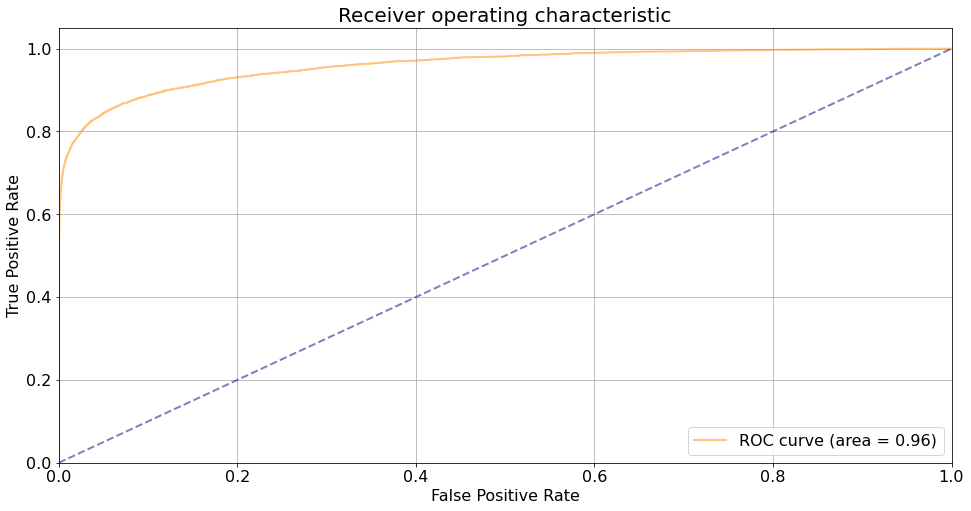

In [ ]:
plt.figure(figsize=(16, 8))
lw=2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

### Результаты

Undersampling | Model | ROC-AUC | 
--- | --- | --- | 
Random Sampler | Logistic Regression | 0.78 | 
Random Sampler | "Logistic Regression" - pytorch.nn | 0.81 |
Random Sampler | CatBoost Classifier | 0.96 | 